In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf
import astropy.units as unit
import astropy.constants as const
import itertools
import plotly.express as px 
import pandas as pd

from axion_functions import *

In [2]:
#Define constants
a = 6.642 #Lattice constant, Angstroms = 1e-10m, from Dent paper. 
hbar_kevs = (const.hbar.to(unit.keV*unit.s)).value #hbar, keV*s, from astropy
c_aas = (const.c.to(unit.AA/unit.s)).value #speed of light, angstrom/s (cancels with a), from astropy

# Define unknown constants
#g_ag = 2e-10 #Axion-photon coupling (Primakoff process), in GeV^(-1).
#Upper bound on g_ag of 2.7e-10 from the Sun, see Di Luzio's review
#lmda = (g_ag/(1e-8))**4
phi_0 = 5.95e14 #in cm^(-2) s^(-1)
E_0    = 1.103 #in keV

#Crystal Geometry
#diam = 110*unit.mm
#hgt = 250*unit.mm 
#vol = ((np.pi*(diam/2)**2*hgt).to(unit.AA**3)).value 
#mass = 5*unit.t #Mass for ton-scale NaI
mass = 50*unit.kg
vol = ((mass/(3.67*unit.g*(unit.cm)**(-3))).to(unit.AA**3)).value #Crystal volume, in AA^3
#Make volume make the mass like 7kg
vol_cell = 67.71 #In AA^3, from Dent paper
t_exposure = 3

s_in_y = 365.25*24*60*60 #Number of seconds in a year

In [162]:
def complete_dndt(max_hkl = 5, print_output = False, condition = "all even", k=[1,0,0], abs_forgot = True, coupling=2e-10, time=3, m_a=0.01, return_energy = False):
    "Axion mass is in keV"
    if condition == "sum even":
        hkl = np.array(make_hkl_s(max_h = max_hkl, 
                                max_k = max_hkl,
                                max_l = max_hkl))
    elif condition == "all even":
        hkl = np.array(make_hkl_double(max_h = max_hkl, 
                                  max_k = max_hkl,
                                  max_l = max_hkl))
    elif condition == "all":
        hkl = np.array(list(itertools.product(range(max_hkl),
                                              range(max_hkl),
                                              range(max_hkl))))[1:]
    else:
        raise NameError("Condition is not one of 'sum even', 'all even', or 'all'")
        
    g_ag = coupling

    g_arr = (2*np.pi/a)*hkl #G vectors, in AA^(-1)

    mod2_g = mod2(g_arr) #Magnitude square of G vectors, 
    FAq_Na = FA_qv2(mod2_g, Z=11)
    FAq_I  = FA_qv2(mod2_g, Z=53)

    ginv_array = 1/mod2_g

    ginv_replicant = np.stack((ginv_array, ginv_array,ginv_array), axis=1)

    ghat = g_arr*np.sqrt(ginv_replicant) # Correct

    if abs_forgot:
        gk = np.abs(gdotk_cart(hkl_to_cart(ghat), k/cart_mag(np.array(k)))) #correct
    else:
        gk = gdotk_cart(hkl_to_cart(ghat), k/cart_mag(np.array(k)))

    sin2 = 4*gk**2*(1-gk**2) 

    if condition == "all even":
        summand = ((FAq_Na+FAq_I)**2)*ginv_array*sin2*64 #*4 from S, *4 from form factor F
    elif condition == "sum even":
        summand = ((FAq_Na+FAq_I)**2)*ginv_array*sin2*4 #Use *4 if implementing s
    else:
        summand = []
        for hkls in hkl:
            if sum(hkls)%2==0: #Even, Constructive sum
                faq_part = (FA_qv2(mod2_hkl_solo((2*np.pi/a)*hkls), Z=11) + FA_qv2((2*np.pi/a)**2*mod2_hkl_solo(hkls), Z=53))**2
            else: #Odd, destructive
                faq_part = (FA_qv2(mod2_hkl_solo((2*np.pi/a)*hkls), Z=11) - FA_qv2((2*np.pi/a)**2*mod2_hkl_solo(hkls), Z=53))**2    
            summand.append(faq_part/mod2_hkl_solo(2*np.pi/a*hkls)*sin2)
        summand = np.array(summand)

    E_arr = hbar_kevs*c_aas*np.sqrt(mod2_g)/(2*gk) #in keV 
    #The infinities here are fine; they go to zero in the W function

    W = w_func(E_arr, E1=1, E2=50, dVector=True, Delta = make_delta(E_arr)) #Delta from Simulation of BG report
    
    #W = w_func(E_arr, E1=1, E2=50, dVector=False, Delta = 1) #Delta from Simulation of BG report
    
    dphi_de = primakoff_flux(E_arr, coupling=g_ag, m_a = m_a) + coalescence_flux(E_arr, coupling=g_ag, m_a = m_a)
    final_summand = W*dphi_de*1e-16*summand #1e-16 to cancel angstroms and cm squared

    nt_constant = np.pi*(g_ag*1e-6)**2*(hbar_kevs*c_aas)**3*vol/(vol_cell**2) #in keV
    if return_energy:
        dct = {"G"   : mod2_g,
               "sin2": sin2,
               "E"   : E_arr,
               "Rate": nt_constant*final_summand #in s^(-1)
               }
        return pd.DataFrame(dct)
    else:
        final_dndt = nt_constant*np.sum(final_summand) #in s^(-1), 1e-16 converts angstroms and cm
        if print_output:
            print("dN/dt = {:.3e} s^(-1)".format(final_dndt))
        return final_dndt*s_in_y*time
# ------------------ Daily modulation
def theta_funcd(theta_func, phi, g_ag=2e-10):
    output = []
    for p in phi:
        k_vec = k_from_polar(theta_func(p), p)
        output.append(complete_dndt(abs_forgot = True, all_even=True, coupling = g_ag, k=k_vec))
    return np.array(output)

def line_integral(theta_func, phi, g_ag=2e-10, t=3, m_a = 0.01):
    dphi = np.diff(phi)
    integral = 0
    for index in range(len(phi)-1):
        p = phi[index]
        k_vec = k_from_polar(theta_func(p), p)
        integral += complete_dndt(abs_forgot = True, condition = "all even", k=k_vec, time=t, coupling=g_ag, m_a = m_a)*dphi[index]
    return integral

def annual_change(coupling = 5.5e-11, time=10, m_a = 0.01):
    output = []
    phi_axis = np.arange(0, 2*np.pi, 0.01)
    for triplet in fits:
        theta_phi = lambda x: cosine_func(x, *triplet)
        output.append(line_integral(theta_phi, phi_axis, g_ag = coupling, t=time, m_a = m_a))
    return np.array(output)

# -------------- Cosine fits
cosine_fits = pd.read_csv("..\\cosine_fits.csv", index_col=0)
def cosine_func(x, amp, phase, vert):
    return amp*np.cos((x-np.pi/180*phase))+vert
fits = np.array(cosine_fits[["a","p","v"]])



def energy_daily(fit_params, dphi = 0.01, coupling=2e-10, time=3, m_a=0.01):
    """Creates the rate/energy data over one dat. fit_params is an array of [a,p,v]"""
    phi_arr = np.arange(0, 2*np.pi, dphi)
    output_E = []
    output_R = []
    for phi in phi_arr:
        theta = cosine_func(phi, *fit_params)
        k_vec = k_from_polar(theta, phi)
        df = complete_dndt(k = k_vec, coupling = coupling, time = time, m_a = m_a, return_energy=True)
        energies = list(np.array(df["E"]))
        rates    = list(np.array(df["Rate"]))
        output_E.extend(energies)
        output_R.extend(rates)
    dct = {"E": output_E,
           "Rate": output_R}
    return pd.DataFrame(dct)

def energy_yearly(fit_array, dphi = 0.01, coupling=2e-10, time=3, m_a=0.01):
    phi_arr = np.arange(0, 2*np.pi, dphi)
    output_E = []
    output_R = []
    for day in fit_array:
        df = energy_daily(day, dphi, coupling=2e-10, time=3, m_a=m_a)
        output_E.extend(list(np.array(df["E"])))
        output_R.extend(list(np.array(df["Rate"])))
    dct = {"E": output_E,
       "Rate": output_R}
    return pd.DataFrame(dct)

In [134]:
86400*0.01/(2*np.pi)

137.50987083139756

In [135]:
one_second = complete_dndt(m_a = 1e-4, coupling=1.23e-10, return_energy = True)

Es = one_second[one_second["E"]<50]["E"]
Rs = one_second[one_second["E"]<50]["Rate"]

C:\Users\taase\AppData\Local\Temp\ipykernel_4052\4288263357.py:53: RuntimeWarning: divide by zero encountered in divide
  E_arr = hbar_kevs*c_aas*np.sqrt(mod2_g)/(2*gk) #in keV


(0.0, 20.0)

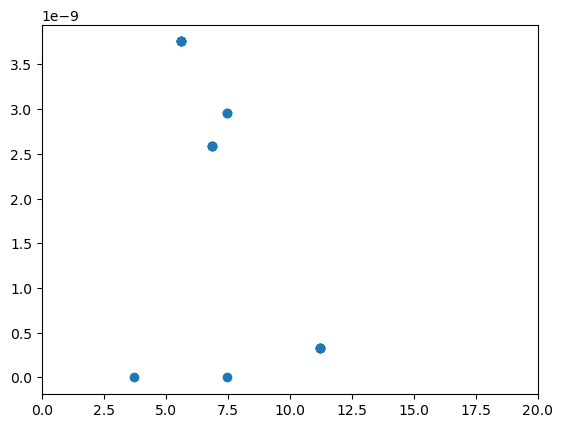

In [136]:
fig,ax = plt.subplots()
ax.scatter(Es, Rs)
ax.set_xlim(0, 20)
#Each point is a cps, but

In [137]:
one_day = energy_daily(fits[0], 0.01, m_a = 1e-4, coupling = 1.23e-10)

C:\Users\taase\AppData\Local\Temp\ipykernel_4052\4288263357.py:53: RuntimeWarning: divide by zero encountered in divide
  E_arr = hbar_kevs*c_aas*np.sqrt(mod2_g)/(2*gk) #in keV
c:\Users\taase\OneDrive\Documents\School\Unimelb\Winter Project\Axion-Flux\Code\axion_functions.py:134: RuntimeWarning: overflow encountered in exp
  val = np.sqrt(lmda)*phi_e0*E*(E**2 - m_a**2)/(np.exp(E/1.1) - 0.7)*(1+0.02*m_a)


In [138]:
Es = one_day[one_day["E"]<50]["E"]
Rs = one_day[one_day["E"]<50]["Rate"]

(0.0, 20.0)

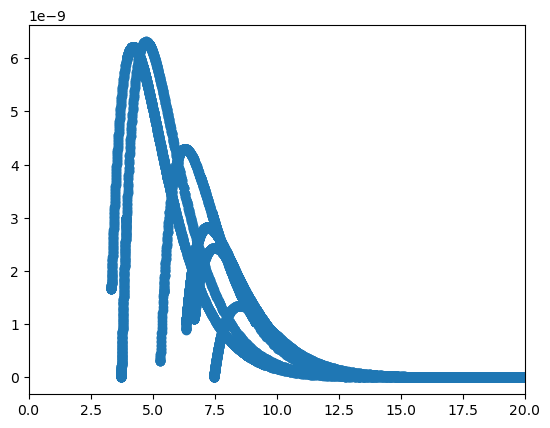

In [152]:
fig,ax = plt.subplots()
ax.scatter(Es, Rs)
ax.set_xlim(0, 20)
#Each point is a cps, but I'm incorporating an entire day. This is summed over, making it a counts per day when I sum

In [158]:
def bin_hist(xdata, ydata, bin_width=1):
    bins = np.arange(min(xdata), max(xdata), bin_width)
    binned_y = []
    dy = np.diff(ydata)
    for index in range(len(bins)-1):
        xmin = bins[index]
        xmax = bins[index+1]
        mask = np.bitwise_and(xdata>xmin, xdata<xmax)
        binned_y.append(sum(ydata[mask]))
    return np.array([bins[:-1], np.array(binned_y)]).transpose()

def bin_hist_v2(xdata, ydata, bin_width=1):
    bins = np.arange(min(xdata), max(xdata), bin_width)
    binned_y = []
    for index in range(len(bins)-1):
        xmin = bins[index]
        xmax = bins[index+1]
        mask = np.bitwise_and(xdata>xmin, xdata<xmax)
        binned_y.append(sum(ydata[mask])/bin_width)
    return np.array([bins[:-1], np.array(binned_y)]).transpose()

In [159]:
binned = bin_hist(Es,Rs, bin_width=0.05)

(0.0, 20.0)

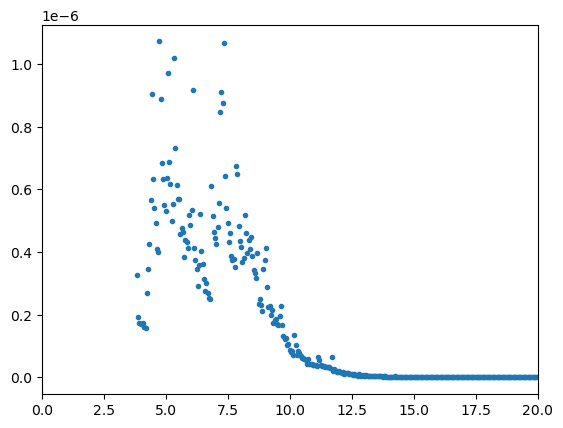

In [160]:
fig,ax = plt.subplots()
ax.scatter(binned[:,0]+1/2, binned[:,1]*86400/50*0.01/(2*np.pi), marker=".")
ax.set_xlim(0, 20)

In [163]:
one_year = energy_yearly(fits[0::50], 0.01)

C:\Users\taase\AppData\Local\Temp\ipykernel_4052\137996946.py:53: RuntimeWarning: divide by zero encountered in divide
  E_arr = hbar_kevs*c_aas*np.sqrt(mod2_g)/(2*gk) #in keV
c:\Users\taase\OneDrive\Documents\School\Unimelb\Winter Project\Axion-Flux\Code\axion_functions.py:134: RuntimeWarning: overflow encountered in exp
  val = np.sqrt(lmda)*phi_e0*E*(E**2 - m_a**2)/(np.exp(E/1.1) - 0.7)*(1+0.02*m_a)


In [164]:
one_year

,E,Rate
0,5.670680,2.524697e-08
1,11.341360,2.062031e-09
2,5.531916,2.727184e-08
3,3.733626,3.557766e-11
4,6.873360,1.836440e-08
...,...,...
130827,15322.547630,0.000000e+00
130828,20.655130,9.625073e-13
130829,2033.087865,0.000000e+00
130830,20.374028,1.222483e-12


In [165]:
Es = one_year[one_year["E"]<50]["E"]
Rs = one_year[one_year["E"]<50]["Rate"]

In [192]:
binned = bin_hist_v2(Es, Rs, bin_width = 0.25)

(0.0, 20.0)

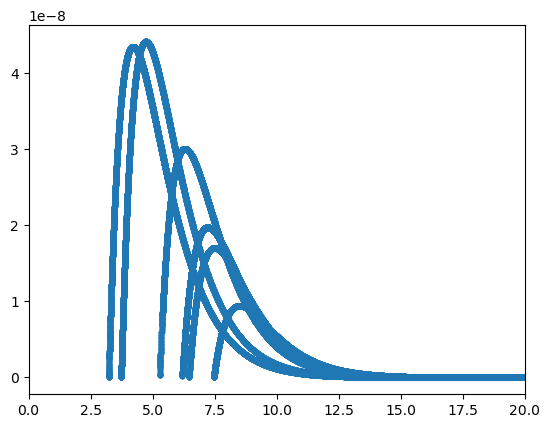

In [193]:
fig,ax = plt.subplots()
ax.scatter(Es, Rs, marker=".")
ax.set_xlim([0,20])
#ax.set_ylim([1e-13,1e-7])
#ax.set_yscale("log")

(0.0, 20.0)

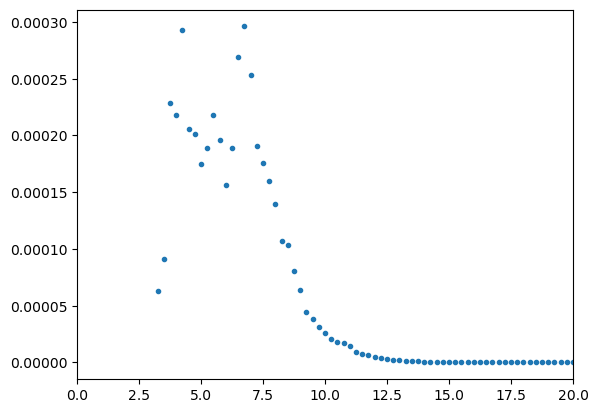

In [194]:
fig,ax = plt.subplots()
ax.scatter(binned[:,0], binned[:,1], marker=".")
ax.set_xlim([0,20])
#ax.set_ylim([1e-13,1e-7])
#ax.set_yscale("log")

In [200]:
normalised = binned[:,1]/np.trapz(binned[:, 1], binned[:, 0])

(0.0, 20.0)

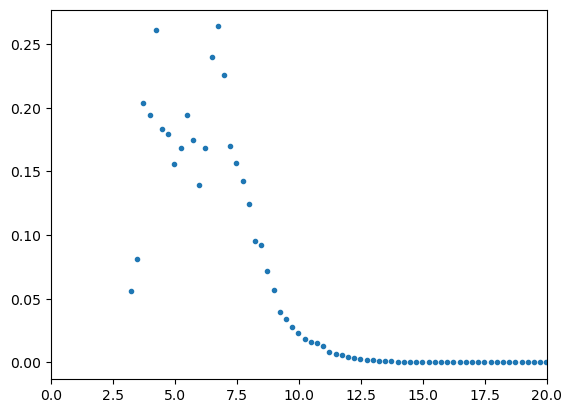

In [201]:
fig,ax = plt.subplots()
ax.scatter(binned[:,0], normalised, marker=".")
ax.set_xlim([0,20])

(0.0, 20.0)

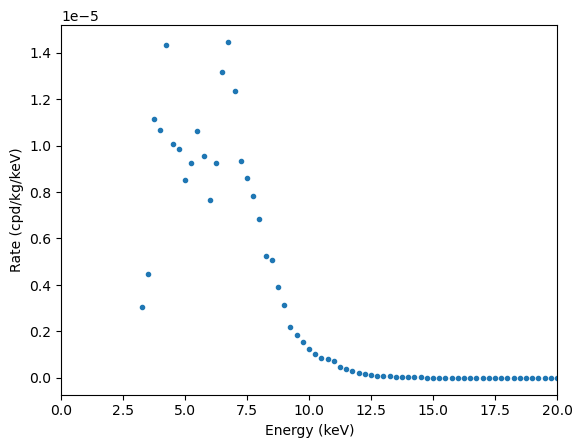

In [206]:
cpd_kg_kev = normalised*5.48e-5 #This is total counts/time/50kg (3/(3*365)/50)
#Directly proportional to counts, independent to time and mass. Thus proportional to g^4
fig,ax = plt.subplots()
ax.scatter(binned[:,0], cpd_kg_kev, marker=".")
plt.ylabel("Rate (cpd/kg/keV)")
plt.xlabel("Energy (keV)")
ax.set_xlim([0,20])

In [205]:
np.trapz(cpd_kg_kev, binned[:,0])*50*365*3

3.0003

In [230]:
bg = np.loadtxt("..\\cosmo_bg.txt")

In [283]:
days = bg[0,:]
bg_rates = bg[1,:]
bg_base = 5.2e-1

bg_total = bg_base + bg_rates

cpd_to_count = 365.25*3*50
cpd_to_ckg = 50*5
N_bg = bg_total*cpd_to_count*5

In [296]:
def make_timely_counts():
    output = []
    for index in range(len(days)-1):
        val = np.trapz(bg_total[:index], days[:index])*50
        output.append(val)
    return np.array(output)

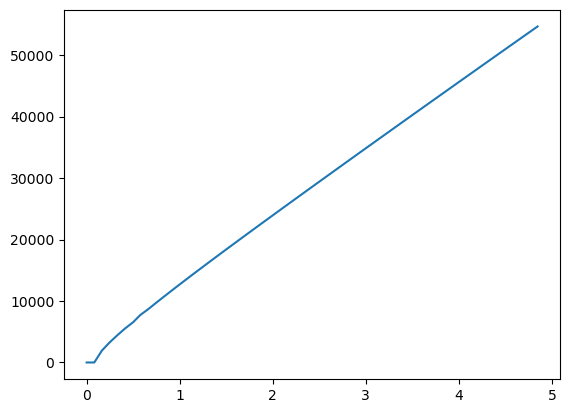

In [297]:
N_bg_time = make_timely_counts()
plt.plot(days[:-1]/365.25, N_bg_time)

In [298]:
n_req = 1.96*np.sqrt(N_bg_time)
n_req/cpd_to_count

array([0.        , 0.        , 0.0015755 , 0.00204056, 0.00237531,
       0.00265414, 0.00289873, 0.00314002, 0.00332093, 0.00350801,
       0.00368301, 0.00384806, 0.00400464, 0.00415394, 0.00429694,
       0.00443436, 0.00456683, 0.00469489, 0.00481898, 0.00493948,
       0.00505668, 0.00517088, 0.0052823 , 0.00539114, 0.00549759,
       0.0056018 , 0.00570391, 0.00580405, 0.00590233, 0.00599887,
       0.00609374, 0.00618704, 0.00627884, 0.00636922, 0.00645824,
       0.00654595, 0.00663241, 0.00671769, 0.00680181, 0.00688482,
       0.00696678, 0.00704771, 0.00712766, 0.00720666, 0.00728474,
       0.00736193, 0.00743827, 0.00751377, 0.00758847, 0.00766239,
       0.00773555, 0.00780797, 0.00787968, 0.0079507 , 0.00802104,
       0.00809072, 0.00815977, 0.00822819, 0.00829601, 0.00836324])

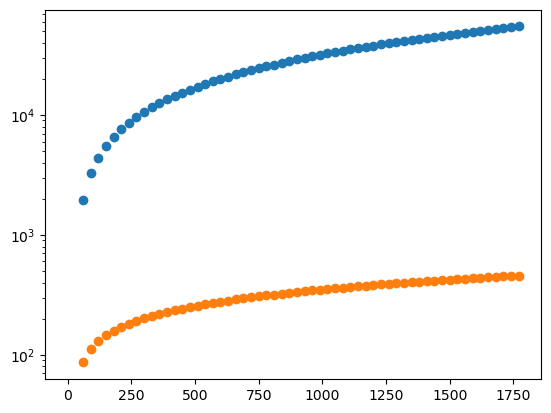

In [299]:
plt.scatter(days[:-1], N_bg_time)
plt.scatter(days[:-1], n_req)
plt.yscale("log")

Get $n(t)$ from the above plot (straight value, no integration or whatever) and set that as the requirement for statistical significance. Use proportionality to determine what value of $g$ would give that number. Multiply by energy range as well

In [330]:
days

array([   0.,   30.,   60.,   90.,  120.,  150.,  183.,  210.,  240.,
        270.,  300.,  330.,  360.,  390.,  420.,  450.,  480.,  510.,
        540.,  570.,  600.,  630.,  660.,  690.,  720.,  750.,  780.,
        810.,  840.,  870.,  900.,  930.,  960.,  990., 1020., 1050.,
       1080., 1110., 1140., 1170., 1200., 1230., 1260., 1290., 1320.,
       1350., 1380., 1410., 1440., 1470., 1500., 1530., 1560., 1590.,
       1620., 1650., 1680., 1710., 1740., 1770., 1800.])

In [331]:
365*5

1825

In [332]:
np.argwhere(days == 1800)

array([[60]], dtype=int64)

In [334]:
n_req[59]

458.20098860652837

In [343]:
(n_req[59]/(mean_123_10*5/3))**(1/4)*1.23e-10

8.972225840086428e-10

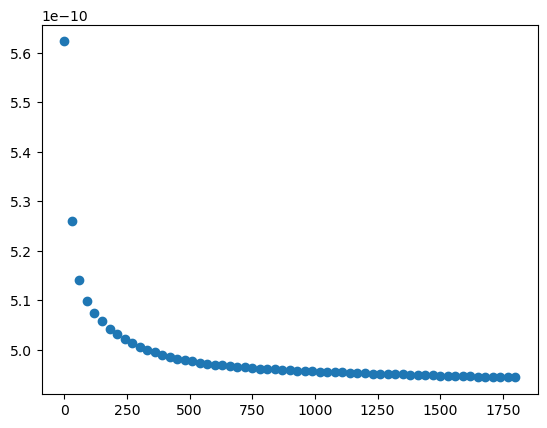

In [266]:
plt.scatter(days, (n_req/3)**(1/4)*1.23e-10)

In [315]:
annual_df = pd.read_csv("annual_changes_mass.csv", index_col=0)
annual_df #g=1.23e-10

,1,5,10
0,18.856662,9.750054,0.558252
1,18.853725,9.754211,0.559778
2,18.850411,9.758694,0.561481
3,18.846883,9.763005,0.563077
4,18.843079,9.768829,0.565283
...,...,...,...
361,18.874938,9.728025,0.555090
362,18.873347,9.730423,0.556003
363,18.862297,9.742793,0.555344
364,18.859916,9.745937,0.556577


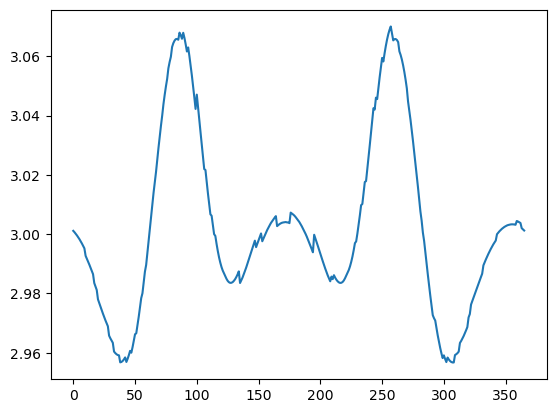

In [312]:
plt.plot(annual_df["1"]/(2*np.pi))

In [327]:
mean_123 = np.mean(annual_df["1"]/(2*np.pi))
mean_123_5 = np.mean(annual_df["5"]/(2*np.pi))
mean_123_10 = np.mean(annual_df["10"]/(2*np.pi))